# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 26

**Author 1 (sciper):** Andrea Oliveri (283506)  
**Author 2 (sciper):** Charles Berger (272018)   
**Author 3 (sciper):** Chun Hei Michael Chan (311722)  

**Release date:** 23.04.2021  
**Due date:** 07.05.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

os.environ["OUTDATED_IGNORE"] = '1'

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [2]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


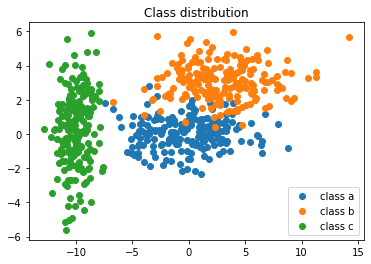

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.scatter(a[:,0],a[:,1],label='class a')
plt.scatter(b[:,0],b[:,1],label='class b')
plt.scatter(c[:,0],c[:,1],label='class c')
plt.title('Class distribution')
plt.legend()
plt.show()

### 1.1 Bayes method (5 pts)
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

In [4]:
# Add your implementation and discussion
import numpy as np

def covariance(array):
    """Function computing the covariance matrix between the dimentions of an array of shape (n_measures, n_dims),
    rounding it to the closest integer value.
    
    Args:
        array::[np.array]
            Array we want to use to compute the covariance of. Has shape (n_measures, n_dims).
    Returns:
        cov::[np.array]
            Covariance matrix computed from array and rounded to nearest integer.
    """
    return np.round(np.cov(array.T)).astype(int)
    
def mean(array):
    """Function computing the mean for each dimention of an array of shape (n_measures, n_dims),
    rounding it to the closest integer value.
    
    Args:
        array::[np.array]
            Array we want to use to compute the mean of. Has shape (n_measures, n_dims).
    Returns:
        mean::[np.array]
            Mean of each dimention computed from array and rounded to nearest integer.
    """
    return np.round(np.mean(array, axis=0)).astype(int)

In [5]:
print('Mean of sample class a: \n{}\n'.format(mean(a)))
print('Mean of sample class b: \n{}\n'.format(mean(b)))
print('Mean of sample class c: \n{}\n'.format(mean(c)))

Mean of sample class a: 
[0 0]

Mean of sample class b: 
[3 3]

Mean of sample class c: 
[-10   0]



In [6]:
print('Covariance of sample class a: \n{}\n'.format(covariance(a)))
print('Covariance of sample class b: \n{}\n'.format(covariance(b)))
print('Covariance of sample class c: \n{}\n'.format(covariance(c)))

Covariance of sample class a: 
[[10  0]
 [ 0  1]]

Covariance of sample class b: 
[[10  0]
 [ 0  1]]

Covariance of sample class c: 
[[1 0]
 [0 5]]



In [7]:
from pingouin import multivariate_normality

def hypothesis_checking(classes, class_names, alpha = 0.05):
    """Function testing whether multivariate distributions of each class are gaussian with confidence alpha, 
    whether the covariance matrices are equal and whether they are diagonal.
    
    Args:
        classes::[list]
            List of arrays each containing the samples belonging to one multivariate class. 
            Each array has shape (n_measures, n_dims).
        class_names::[list]
            List of strings containing the label assigned to each class.
        alpha::[float]
            Confidence used in the Henze-Zirkler test for multivariate normality.
    Returns:
        None
    """
    assert len(classes) == len(class_names), f"Expected parameters classes and class_names to be lists of same length. Got len(classes) = {len(classes)} and len(class_names) = {len(class_names)}"
    
    # Test if data from each class follows a multivariate gaussian distribution.
    for class_, class_name in zip(classes, class_names):
        stat, p, gaussian = multivariate_normality(class_, alpha)
        print("Multivariate normality test for Class {}:".format(class_name))
        print("    Henze-Zirkler test statistic: {:.4f} and p_value = {:.4f}".format(stat, p))
        print("    The multivariate distribution of Class {} {}\n".format(class_name, "looks Gaussian" if gaussian else "does not look Gaussian"))
    
    # Determine if mean of each class are different.
    means = [mean(class_) for class_ in classes]
    
    already_tested_combinations = []
    for first_mean, first_class_name in zip(means, class_names):
        for second_mean, second_class_name in zip(means, class_names):
            if first_class_name != second_class_name and (second_class_name, first_class_name) not in already_tested_combinations:
                print("Mean of Classes {} and {} are {}.".format(first_class_name, second_class_name, "equal" if np.array_equal(first_mean, second_mean) else "different"))
                already_tested_combinations.append( (first_class_name, second_class_name) )

    print()
    
    # Determine if covariance matrices of each class are equal.
    covariances = [covariance(class_) for class_ in classes]
    
    already_tested_combinations = []
    for first_covariance, first_class_name in zip(covariances, class_names):
        for second_covariance, second_class_name in zip(covariances, class_names):
            if first_class_name != second_class_name and (second_class_name, first_class_name) not in already_tested_combinations:
                print("Covariance matrices of Classes {} and {} are {}.".format(first_class_name, second_class_name, "equal" if np.array_equal(first_covariance, second_covariance) else "different"))
                already_tested_combinations.append( (first_class_name, second_class_name) )

    print()

    # Determine if covariance matrices are diagonal.
    for class_covariance, class_name in zip(covariances, class_names):
        covariance_no_diagonal = class_covariance.copy()
        np.fill_diagonal(covariance_no_diagonal, 0.)
        is_diagonal = np.sum(covariance_no_diagonal) == 0.
        print("Covariance matrix of Class {} is{}diagonal.".format(class_name, " " if is_diagonal else " not "))
        
    
                
hypothesis_checking([a, b, c], ["a", "b", "c"])

Multivariate normality test for Class a:
    Henze-Zirkler test statistic: 0.5393 and p_value = 0.6484
    The multivariate distribution of Class a looks Gaussian

Multivariate normality test for Class b:
    Henze-Zirkler test statistic: 0.5991 and p_value = 0.5224
    The multivariate distribution of Class b looks Gaussian

Multivariate normality test for Class c:
    Henze-Zirkler test statistic: 0.4358 and p_value = 0.8510
    The multivariate distribution of Class c looks Gaussian

Mean of Classes a and b are different.
Mean of Classes a and c are different.
Mean of Classes b and c are different.

Covariance matrices of Classes a and b are equal.
Covariance matrices of Classes a and c are different.
Covariance matrices of Classes b and c are different.

Covariance matrix of Class a is diagonal.
Covariance matrix of Class b is diagonal.
Covariance matrix of Class c is diagonal.


What we can conclude from the measures and tests performed in the previous two cells is that:
- Each class follows a multivariate normal distribution.
- The means of the classes are all different. If they are sufficiently far in relation to the covariance matrices, we can hope for a good classifier.
- The covariance matrices across different classes are not all identical.
- The covariance matrices of each class, when rounded to the closest integer, are perfectly diagonal.

The general discriminant function, assuming that each class follows a multivariate normal distribution (which we have verified previously) is:

\begin{equation}
    g_i(x) = \ln(p(x|w_i)) + \ln(P(w_i)) \\
    g_i(x) = -\frac{1}{2}x^T\Sigma_i^{-1}x+ \frac{1}{2}x^T\Sigma_i^{-1}\mu_i -\frac{1} {2}\mu_i^T\Sigma_i^{-1}\mu_i + \frac{1}{2}\mu_i^T\Sigma_i^{-1}x + \ln(P(w_i)) + c_i 
\end{equation}

By considering the constant value to be the same across classes and since our sample size is also the same across classes, we can leave out the `ln(P(w_i)) + c_i` from our formula as they will later cancel out when testing $g_i(x) > g_j(x)$ for any $i, j \in \{a,b,c\}$.

By substituting in the formula the computed (and rounded to closest integer) parameters of each distribution, we obtain the following discriminant functions for each class:

\begin{align}
g_a(x) &= -\frac{1}{2}\left(\frac{1}{10}x_1^2+x_2^2 \right) \\
g_b(x) &= -\frac{1}{2}\left(\frac{1}{10}x_1^2+x_2^2 \right) + \left(\frac{3}{10}x_1 + 3x_2 \right) - \frac{99}{20} \\ 
g_c(x) &= -\frac{1}{2}\left(x_1^2+\frac{1}{5}x_2^2 \right) - 10x_1 - 50
\end{align}

We can now compute the boundaries between each pair of classes. The boundaries between two classes are defined by the set of points $(x_1, x_2) \in \mathbb{R}^2$ such that:
- Boundary between class a and class b:
    $$d_{ab}(x) = g_{a}(x) - g_{b}(x) = -\left(\frac{3}{10}x_1 + 3x_2 \right) + \frac{99}{20} = 0$$
- Boundary between class a and class c:
    $$d_{ac}(x) = g_{a}(x) - g_{c}(x) = \frac{1}{2} \left(\frac{9}{10}x_1^2-\frac{4}{5}x_2^2 \right)+10x_1+50=0 $$
- Boundary between class b and class c:
    $$d_{bc}(x) = g_{b}(x) -g_{c}(x) = \frac{1}{2} \left(\frac{9}{10}x_1^2-\frac{4}{5}x_2^2 \right)+\frac{103}{10}x_1+3x_2+\frac{901}{20}=0  $$

The overall decision boundary between the three classes is then given by $h(x) = 0$ for $h: I \times J \rightarrow \mathbb{R}$, with $I,J\subset \mathbb{R}^2$ :

\begin{equation}
h(x) = 
     \begin{cases}
       d_{ab}(x) &\quad\text{when } d_{ac}(x) \ge 0, d_{bc}(x) \ge 0\\
       d_{ac}(x) &\quad\text{when } d_{ab}(x) \ge 0\\
       d_{bc}(x) &\quad\text{when } d_{ab}(x) \le 0\\
     \end{cases}
\
\end{equation}

In [8]:
def d_ab(x1, x2):
    """Function returning the value of the decision function between class a and class b.
    
    Args:
        x1::[np.array]
            First coordinate of points at which we want to evaluate decision function.
        x2::[np.array]
            Second coordinate of points at which we want to evaluate decision function.
    Returns:
        value::[np.array]
            Value of the decision function between class a and class b evaluated at points (x1, x2).
    """
    return - 3/10*x1 - 3*x2 + 99/20


def d_ac(x1, x2):
    """Function returning the value of the decision function between class a and class c.
    
    Args:
        x1::[np.array]
            First coordinate of points at which we want to evaluate decision function.
        x2::[np.array]
            Second coordinate of points at which we want to evaluate decision function.
    Returns:
        value::[np.array]
            Value of the decision function between class a and class c evaluated at points (x1, x2).
    """
    return 1/2*(9/10*x1**2-4/5*x2**2) + 10*x1 + 50


def d_bc(x1, x2):
    """Function returning the value of the decision function between class b and class c.
    
    Args:
        x1::[np.array]
            First coordinate of points at which we want to evaluate decision function.
        x2::[np.array]
            Second coordinate of points at which we want to evaluate decision function.
    Returns:
        value::[np.array]
            Value of the decision function between class b and class c evaluated at points (x1, x2).
    """
    return 1/2*(9/10*x1**2-4/5*x2**2) + 103/10*x1 + 3*x2 + 901/20


def classify_bayes(x1, x2, use_class_c = True):
    """Function classifying each point described by (x1, x2) using Bayes Classifier. 
    Classes assignements are as follows: a -> 0, b -> 1, c -> 2.
    
    Args:
        x1::[np.array]
            First coordinate of points at which we want to classify.
        x2::[np.array]
            Second coordinate of points at which we want to classify.
        use_class_c::[bool]
            Whether to include class c in the predictions, or only use classes a and b.
    Returns:
        pred::[np.array]
            Prediction of the class to which the points (x1, x2) belong.
    """
    if use_class_c:
        d_ab_ = d_ab(x1, x2)
        d_ac_ = d_ac(x1, x2)
        d_bc_ = d_bc(x1, x2)

        pred = np.zeros_like(x1)
        pred[np.logical_and(d_ab_ >= 0, d_ac_ >= 0)] = 0
        pred[np.logical_and(d_ab_ >= 0, d_ac_ <  0)] = 2
        pred[np.logical_and(d_ab_ <  0, d_bc_ >= 0)] = 1
        pred[np.logical_and(d_ab_ <  0, d_bc_ <  0)] = 2
        
    else:
        d_ab_ = d_ab(x1, x2)
        pred = np.zeros_like(x1)
        pred[d_ab_ < 0] = 1
        
    return pred

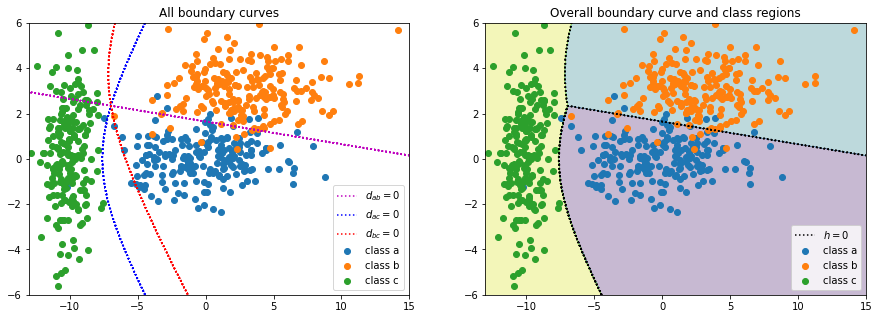

In [9]:
x1_min = np.floor(np.min([a[:,0], b[:,0], c[:,0]]))
x1_max = np.ceil (np.max([a[:,0], b[:,0], c[:,0]]))
x2_min = np.floor(np.min([a[:,1], b[:,1], c[:,1]]))
x2_max = np.ceil (np.max([a[:,1], b[:,1], c[:,1]]))

# Create 1-D arrays for horizontal and vertical dimensions.
resolution_mesh = 1000
x1_list = np.linspace(x1_min, x1_max, resolution_mesh) 
x2_list = np.linspace(x2_min, x2_max, resolution_mesh) 

# Create 2-D grid of points filling the whole plot.
x1_meshgrid, x2_meshgrid = np.meshgrid(x1_list, x2_list)
d_ab_points = d_ab(x1_meshgrid, x2_meshgrid) > 0
d_ac_points = d_ac(x1_meshgrid, x2_meshgrid) > 0
d_bc_points = d_bc(x1_meshgrid, x2_meshgrid) > 0
h_points    = classify_bayes(x1_meshgrid, x2_meshgrid)

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

# Plot contour lines.
d_ab_contour = ax[0].contour (x1_meshgrid, x2_meshgrid, d_ab_points, colors = 'm', linestyles = 'dotted')
d_ac_contour = ax[0].contour (x1_meshgrid, x2_meshgrid, d_ac_points, colors = 'b', linestyles = 'dotted')
d_bc_contour = ax[0].contour (x1_meshgrid, x2_meshgrid, d_bc_points, colors = 'r', linestyles = 'dotted')
h_contour    = ax[1].contour (x1_meshgrid, x2_meshgrid, h_points   , colors = 'k', linestyles = 'dotted')
h_contourf   = ax[1].contourf(x1_meshgrid, x2_meshgrid, h_points, alpha = 0.3)
d_ab_contour.collections[0].set_label("$d_{ab} = 0$")
d_ac_contour.collections[0].set_label("$d_{ac} = 0$")
d_bc_contour.collections[0].set_label("$d_{bc} = 0$")
h_contour   .collections[0].set_label("$h = 0$")

# Plot points in both subplots.
for ax_iter in ax:
    ax_iter.scatter(a[:,0], a[:,1], label = 'class a')
    ax_iter.scatter(b[:,0], b[:,1], label = 'class b')
    ax_iter.scatter(c[:,0], c[:,1], label = 'class c')
    ax_iter.legend()

ax[0].set_title('All boundary curves')
ax[1].set_title('Overall boundary curve and class regions');

Categorical accuracy over all three classes: 0.965


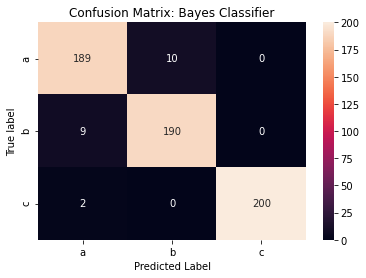

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

pred_a = classify_bayes(a[:, 0], a[:, 1])
pred_b = classify_bayes(b[:, 0], b[:, 1])
pred_c = classify_bayes(c[:, 0], c[:, 1])

pred_all   = np.asarray([pred_a, pred_b, pred_c]).flatten()
target_all = np.asarray([np.full_like(pred_a, 0), np.full_like(pred_b, 1), np.full_like(pred_c, 2)]).flatten()

conf_matrix = confusion_matrix(pred_all, target_all)

print('Categorical accuracy over all three classes: {}'.format(np.mean(pred_all == target_all)))

ax = sns.heatmap(conf_matrix, annot = True, fmt = 'g')
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True label")
ax.set_xticklabels(["a", "b", "c"])
ax.set_yticklabels(["a", "b", "c"])
plt.title('Confusion Matrix: Bayes Classifier');

#### Discussion
##### Description of the processing : 

- In order to perform a Bayesian Classification, we assume that the classes follow a Multivariate Gaussian distribution. We check later if this assumptions holds by doing an hypothesis test using the `multivariate_normality` function from the `pingouin` library, which implements a Henze-Zirkler test. 

    <br/>
    
- Secondly, we calculated the mean and covariance matrix of each class. We round them to the nearest interger. We check if they are equal for all classes and diagonal. 

    <br/>
    
- Based on the previous results, we compute and simplify if possible the discriminant function for each class. The results and calculations are shown previously.

    <br/>
    
- Finally, we plotted the class data points, decision boundaries and class regions for each class, as well as the confusion matrix of the classifier. The decision boundaries are the set of points for which the point has equal probability of belonging to two classes. The class regions are partitions of the input space for which a data point is classified as a specific class.

    <br/>

##### General comment on method :

- The method achieves very good classification results, and under the assumption that the data is indeed gaussian (which we verified statistically), and that the covariance matrices are diagonal (different features of the data are uncorrelated) it is the best classifier that can be constructed for this data (neglecting the rounding errors obtained when computing mean and covariance of each class). Additionally, the method is very simple to implement and runs fast.

    <br/>

- It is important to note that, if the data didn't indeed come from a Multivariate Gaussian distribution, or if the covariance matrices weren't diagonal, the accuracy achieved by this method would drop sharply.

    <br/>

- Finally, our method neglects the prior probabilities as in our dataset the points were artificially generated inequal numbers, but for real data the prior should be correctly estimated and accounted for (in some cases it can easily be determined from the dataset, in other cases the dataset may be such that identical priors are enforced on all classes).

##### Comment on results : 

- The decision lines obtained gave quite a good classification of the data and separate well each class. However, some issues must be assessed. 

    <br/>
 
    - Between class `class a` and `class b`, some points are misclassified. This can be explained by the fact that the inter class variances of these classes are small compared to their intra class variance. We don't have a perfect separation between `class a` and `class b` resulting in a mixing between some points of both classes.
    
    <br/>
        
    - Between `class c` and the other two classe there are much less points misclassified than between `class a` and `class b`, which is due to a larger inter class variance. Nonetheless, we have a couple of points of `class c` which get misclassified.
                     
##### Comparison to other methods / variants : 

- for `class a` and `class b`, the Mahalanobis distance classifier gives the same classification results, which is expected as these two classes have the same covariance matrix, and hence both Bayes and Mahalanobis distance classifier are expected to be ideal.

    <br/>

- The use of other methods (ex: CNN, ...) might give better classification results on the training set by finding a mapping into a feature space such that the inter class variances become much larger than the intra class variances, but this would likely lead to overfitting the data. 

### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

<b> Part 1 </b>

Once again, we make the assumptions that our classes follow a Multivariate Normal distribution (which we have verified) and that the covariance matrices of each class are diagonal (which we also verified after rounding to the closest integer). Additionally, we also proved the covariance matrices of `a` and `b` are the same (after rounding to closest integer).

Mahalanobis Distance: 
\begin{equation}
    d = ((x-\mu_i)^T \Sigma^{-1}(x-\mu_i))^{1/2} \\ 
    d_a = \sqrt{\frac{1}{10} x_1^2+x_2^2} \\ 
    d_b = \sqrt{\frac{1}{10} (x_1-3)^2+(x_2-3)^2}
\end{equation}

In [11]:
# Add your implementation and discussion
def d_a(x1, x2):
    """Function returning the value of the Mahalanobis distance of points (x1, x2) from class a. 
    
    Args:
        x1::[np.array]
            First coordinate of points at which we want to compute the distance.
        x2::[np.array]
            Second coordinate of points at which we want to compute the distance.
    Returns:
        d_a::[np.array]
            Computed Mahalanobis distance of points (x1, x2) from class a.
    """
    return np.sqrt(1/10*x1**2 + x2**2)


def d_b(x1, x2):
    """Function returning the value of the Mahalanobis distance of points (x1, x2) from class b. 
    
    Args:
        x1::[np.array]
            First coordinate of points at which we want to compute the distance.
        x2::[np.array]
            Second coordinate of points at which we want to compute the distance.
    Returns:
        d_b::[np.array]
            Computed Mahalanobis distance of points (x1, x2) from class b.
    """
    return np.sqrt(1/10*(x1-3)**2 + (x2-3)**2)


def classify_mahalanobis(x1, x2):
    """Function classifying each point described by (x1, x2) using a Mahalanobis distance classifier.
    Classes assignements are as follows: a -> 0, b -> 1.
    
    Args:
        x1::[np.array]
            First coordinate of points at which we want to classify.
        x2::[np.array]
            Second coordinate of points at which we want to classify.
    Returns:
        pred::[np.array]
            Prediction of the class to which the points (x1, x2) belong.
    """
    return (d_a(x1, x2) >= d_b(x1, x2)).astype(np.int)

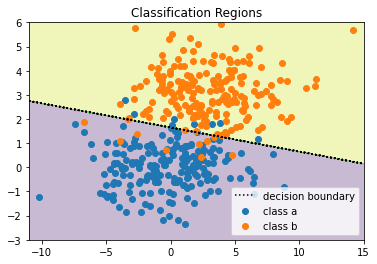

In [12]:
x1_min = np.floor(np.min([np.min(a[:,0]), np.min(b[:,0])]))
x1_max = np.ceil (np.max([np.max(a[:,0]), np.max(b[:,0])]))
x2_min = np.floor(np.min([np.min(a[:,1]), np.min(b[:,1])]))
x2_max = np.ceil (np.max([np.max(a[:,1]), np.max(b[:,1])]))

resolution_mesh = 1000
x1_list = np.linspace(x1_min, x1_max, resolution_mesh) 
x2_list = np.linspace(x2_min, x2_max, resolution_mesh) 

x1_meshgrid, x2_meshgrid = np.meshgrid(x1_list, x2_list)
class_ab = classify_mahalanobis(x1_meshgrid, x2_meshgrid)

h_contour  = plt.contour (x1_meshgrid, x2_meshgrid, class_ab, colors = 'k', linestyles = 'dotted')
h_contourf = plt.contourf(x1_meshgrid, x2_meshgrid, class_ab, alpha = 0.3)
h_contour.collections[0].set_label("decision boundary")

plt.scatter(a[:,0], a[:,1], label='class a')
plt.scatter(b[:,0], b[:,1], label='class b')

plt.legend()
plt.title('Classification Regions')
plt.show()

Categorical accuracy over the two classes: 0.965


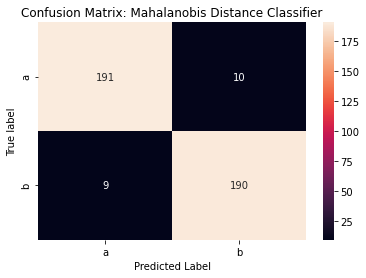

In [13]:
pred_a = classify_mahalanobis(a[:, 0], a[:, 1])
pred_b = classify_mahalanobis(b[:, 0], b[:, 1])

pred_ab   = np.asarray([pred_a, pred_b]).flatten()
target_ab = np.asarray([np.full_like(pred_a, 0), np.full_like(pred_b, 1)]).flatten()

conf_matrix = confusion_matrix(pred_ab, target_ab)

print('Categorical accuracy over the two classes: {}'.format(np.mean(pred_all == target_all)))

ax = sns.heatmap(conf_matrix, annot = True, fmt = 'g')
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True label")
ax.set_xticklabels(["a", "b"])
ax.set_yticklabels(["a", "b"])
plt.title('Confusion Matrix: Mahalanobis Distance Classifier');

<b> Part 2 </b>

Proportion of Predictions which are the same for Bayes Classifier and Mahalanobis Classifier: 1.0


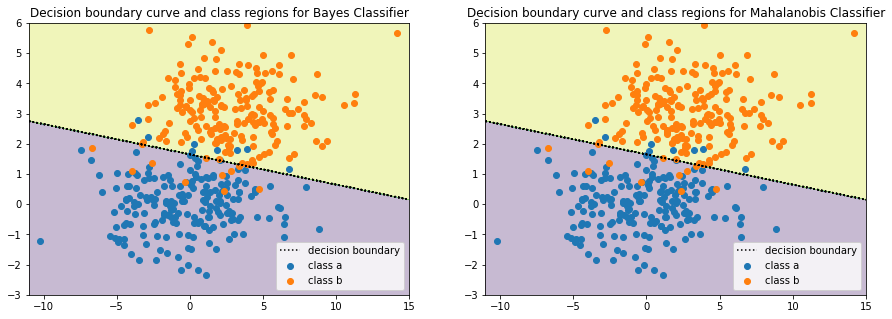

In [14]:
resolution_mesh = 1000
x1_list = np.linspace(x1_min, x1_max, resolution_mesh) 
x2_list = np.linspace(x2_min, x2_max, resolution_mesh) 

x1_meshgrid, x2_meshgrid = np.meshgrid(x1_list, x2_list)
class_ab_bayes       = classify_bayes      (x1_meshgrid, x2_meshgrid, use_class_c = False)
class_ab_mahalanobis = classify_mahalanobis(x1_meshgrid, x2_meshgrid)

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

h_contour  = ax[0].contour (x1_meshgrid, x2_meshgrid, class_ab_bayes, colors = 'k', linestyles = 'dotted')
h_contourf = ax[0].contourf(x1_meshgrid, x2_meshgrid, class_ab_bayes, alpha = 0.3)
h_contour.collections[0].set_label("decision boundary")

h_contour  = ax[1].contour (x1_meshgrid, x2_meshgrid, class_ab_mahalanobis, colors = 'k', linestyles = 'dotted')
h_contourf = ax[1].contourf(x1_meshgrid, x2_meshgrid, class_ab_mahalanobis, alpha = 0.3)
h_contour.collections[0].set_label("decision boundary")

for ax_iter in ax:
    ax_iter.scatter(a[:,0], a[:,1], label='class a')
    ax_iter.scatter(b[:,0], b[:,1], label='class b')
    ax_iter.legend()
    
ax[0].set_title('Decision boundary curve and class regions for Bayes Classifier')
ax[1].set_title('Decision boundary curve and class regions for Mahalanobis Classifier')

print("Proportion of Predictions which are the same for Bayes Classifier and Mahalanobis Classifier:", np.mean(class_ab_bayes == class_ab_mahalanobis))

#### Discussion : 

##### Description of the process : 

- In order to perform a Mahalanobis distance Classification, we assume that the classes follow a Multivariate Gaussian distribution. We checked this assumptions holds by doing an hypothesis test using the `multivariate_normality` function from the `pingouin` library, which implements a Henze-Zirkler test. Moreover, we checked that the matrices for the two classes are the same (rounded to the closest integer), and hence we expect the Mahalanobis Classifier to perform as well as a Bayes Classifier on this problem.

    <br/>
    
- Based on the computed covariance matrices and means, we calculate an analytical function for the Mahalanobis with respect to each class.

    <br/>

- Finally, we plotted the class data points, decision boundaries and class regions for each class, as well as the confusion matrix of the classifier. The decision boundaries are the set of points for which the point has equal probability of belonging to two classes. The class regions are partitions of the input space for which a data point is classified as a specific class.

    <br/>
    
- To compare the Mahalanobis distance classifier with the Bayes Classifier, we evaluated both classifiers over a large sets of points and compared their predictions and decision boundaries.

    <br/>

##### General comment on method : 

- The method achieves very good classification results, and under the assumption that the data is indeed gaussian (which we verified statistically), and that the covariance matrices of the two classes are the same (which we also verified), it is the best classifier that can be constructed for this data (neglecting the rounding errors obtained when computing mean and covariance of each class). Additionally, the method is very simple to implement and runs fast.

    <br/>

- It is important to note that, if the data didn't indeed come from a Multivariate Gaussian distribution, or if the covariance matrices weren't the same for the two classes, the accuracy achieved by this method would drop sharply.

    <br/>

##### Comment on results : 

- The decision line and predictions of the Mahalanobis distance classifier perfectly correspond to those obtained with the Bayesian classifier.

    <br/>

- The decision line obtained gave quite a good classification of the data and separate well the classes. Nevertheless, there were still some points which were misclassified for the same reasons as explained earlier. 

    <br/>

##### Comparison to other methods / variants : 

- The same remarks done in the previous section also apply here.

---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [15]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [16]:
!ls ../data/lab-03-data/part2/

"ls" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [17]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

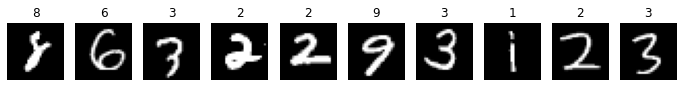

In [18]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [19]:
# Add your implementation and discussion
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha = 1e-4, hidden_layer_sizes = (100,), max_iter = 500, early_stopping = True)

clf.fit(train_images.reshape(train_images.shape[0], -1), train_labels);

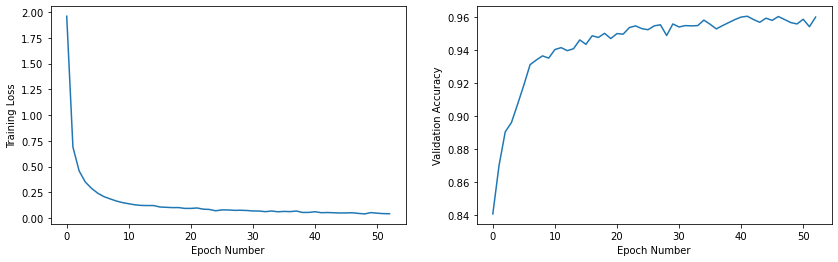

In [20]:
fig, (ax_train_loss, ax_val_acc) = plt.subplots(1, 2, figsize = (14, 4), sharex = True)
ax_train_loss.plot(clf.loss_curve_)
ax_train_loss.set_xlabel("Epoch Number")
ax_train_loss.set_ylabel("Training Loss")

ax_val_acc.plot(clf.validation_scores_)
ax_val_acc.set_xlabel("Epoch Number")
ax_val_acc.set_ylabel("Validation Accuracy");

Training Accuracy: 0.9865
Test     Accuracy: 0.9622


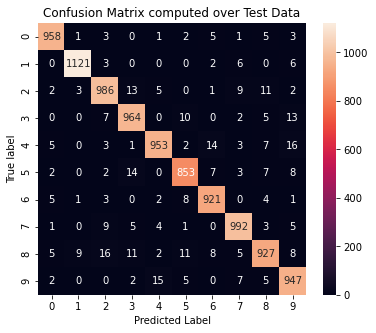

In [21]:
print("Training Accuracy: {:.4f}".format(clf.score(train_images.reshape(train_images.shape[0], -1), train_labels)))
print("Test     Accuracy: {:.4f}".format(clf.score(test_images .reshape(test_images .shape[0], -1), test_labels)))

test_pred = clf.predict(test_images.reshape(test_images.shape[0], -1))

plt.figure(figsize = (6, 5))
ax = sns.heatmap(confusion_matrix(test_pred, test_labels), annot = True, fmt = 'g')
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True label")
plt.title("Confusion Matrix computed over Test Data")
plt.show()

#### Discussion
##### Description of the processing : 

- Each image in the training and test set was flattened into a vector.

    <br/>

- The original training set was split into a training and validation set (validation set composed of 10% of original training samples).

    <br/>

- The new training set was used to train the Multi-Layer Perceptron. A small L2 regularization was applied to the weights of the net to reduce the risk of overfitting. ReLU was used as activation function for the hidden layer, and softmax was used for the output layer. The Multi-Layer Perceptron was trained until no improvements were seen on the validation accuracy. 

    <br/>

##### General comment on method :

- The method uses a very flexible model capable of adapting to different datasets and tasks. In our case, we use a net to perform classification of digits in the MNIST dataset, so we used a small net with relatively few parameters. Nevertheless, even with this small net, the time required to train the model was in the order of 45 seconds on a Intel Core i7-7700HQ, showing that the flexibility of a Neural Network comes at the cost of considerable computational complexity. 

    <br/>

##### Comment on results : 

- The Neural Network trained successfully, achieving both good training and validation accuracy (both consistently well above 95%).

    <br/>
    
- The successful training is confirmed by the plot of the training loss over epoch number, which shows a convergence to a much smaller value than the starting one, as well as the plot of validation accuracy over epoch number, which shows the validation accuracy reaching a value close to 1.

    <br/>
 
- As can be seen from the confusion matrix computed over the test data, the vast majority of predictions are correct (confusion matrix values on diagonal are very large) and no clear pattern can be seen outside the diagonal of the confusion matrix consistently across runs.

    <br/>

##### Comparison to other methods / variants:

- A finer hyper-parameter tuning for alpha, tol, activation, batch_size, adam parameters, etc. could have been performed, and some configurations could have resulted in better train and test accuracy consistently achieved over several runs compared to our final configuration. However, this would have required large amounts of time and resources, and we decided to settle for our configuration which consistently yielded very good results nonetheless.